In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Introduction


<font color = 'red'>
Content: 

1. [Import Libraries](#1)
1. [Select Device](#2)
1. [Import Dataset](#3)
1. [Read Data](#4)
1. [Data Process](#5)
    * [Transforms](#6)
    * [Data Loader](#7)
1. [Visualization](#8)
1. [CNN Model](#9)
    * [Create Model](#10)
    * [Initial Parameters](#11)
1. [Training](#12)
1. [Testing](#13)
1. [Visualization Results](#14)
1. [Save Model](#15)
    

<a id = "1"></a><br>

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import time

We initialize constant variable. if we want to change variables, we can do there easily.

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--save-model', action='store_true', default="/save_model.pth",
                        help='For Saving the current Model')
    args = parser.parse_args()

<a id = "2"></a><br>

# Select Device

In this chapter we will use select device. There are two devices: GPU and CPU. We will choose GPU devices because GPU much faster than CPU.

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

Do not worry. If your devices is not available to using GPU, This function select CPU devices.

<a id = "3"></a><br>

# Import Dataset

we will import MNIST dataset. We will create funtion. This function is for custom dataset. Also the function is for csv file.

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(28, 28, 1)

        if self.transforms:
            data = self.transforms(data)

        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

<a id = "4"></a><br>

# Read Data

We will use two csv files. these files for train and test. But this dataset is not include validation set. If you want to use validation set, you can split training set.

In [9]:
df_train = pd.read_csv('../input/digit-recognizer/train.csv')
df_test = pd.read_csv('../input/digit-recognizer//test.csv')

In [21]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [10]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [11]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These images size is 28x28  so there are 784 numbers. Each colon respresents one piksel. Training set has label and image's pixsels but test set does not have. 

In [13]:
train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:, 1:]
test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]


In [14]:
train_labels

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [15]:
train_images.size

32928000

In [16]:
train_images.shape

(42000, 784)

In [17]:
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
27995    0
27996    0
27997    0
27998    0
27999    0
Name: pixel0, Length: 28000, dtype: int64

In [18]:
test_images.size

21924000

In [19]:
test_images.shape

(28000, 783)

<a id = "5"></a><br>

# Data Process

<a id = "6"></a><br>

# Transforms

We must convert images to tensor.

In [23]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
])

<a id = "7"></a><br>

# Data Loader

we applied transorms. In this chapter we will load data.

In [25]:
train_data = MNISTDataset(df_train.iloc[:, 1:], train_labels, transform)
test_data = MNISTDataset(df_test.iloc[:, 0:], test_labels, transform)

In [26]:
trainloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=True)

We selected batch size is 128. There are  42000 images and our batch size is 128 so Each bath size has got 330 images.

<a id = "8"></a><br>

# Visualization

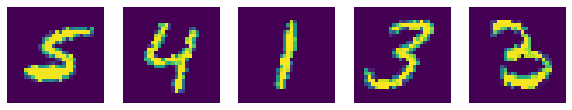

In [27]:
def get_random_images(num):

    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data,
                       sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels


to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

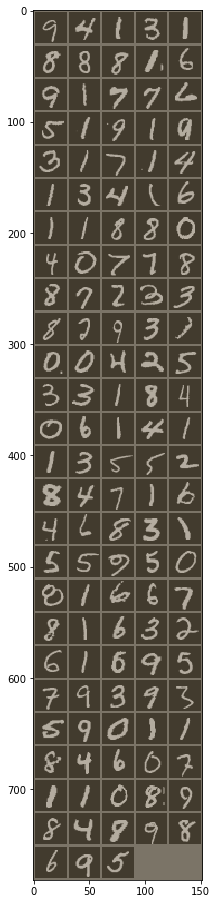

In [34]:
for images, labels in trainloader:
    break
im = make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
    mean= [-0.485/0.225,
    -0.456/0.224,
    -0.406/0.225],
    std= [1/0.225, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize=(8,16))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))
plt.show()

<a id = "9"></a><br>

# CNN Model

<a id = "10"></a><br>

# Create Model

We make six layers. we will use dropout function to drop overfitting. 

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
            nn.ReLU())

        self.fc1 = nn.Linear(1152, 10)



    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc1(out))
        return out


cnn = CNN().to(device)

<a id = "11"></a><br>

# Initial Parameters

In [ ]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(args.seed)

examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=args.lr)

epochs = args.epochs

<a id = "12"></a><br>

# Training

In [ ]:
trainloss = []


def train(cnn):
    start = time.time()

    for epoch in range(epochs):
        running_loss = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            trainloss.append(loss)
            optimizer.step()

            running_loss += loss.item()
            print('[Epoch %d] loss: %.3f' %
                  (epoch + 1, running_loss / len(trainloader)))

            predicted = torch.max(outputs.data, 1)[1]


            if i % 100 == 99:
                grid = torchvision.utils.make_grid(inputs)


            
    end = time.time()

    print('Done Training')
    print('%0.2f minutes' % ((end - start) / 60))

    return cnn


train(cnn)

<a id = "13"></a><br>

# Testing

In [ ]:
testloss = []

def test():
    correct = 0
    total  = len(test_data)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(inputs)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    loss = criterion(outputs, labels)
    testloss.append(loss)
    testcorrect.append(correct)
    print('Accuracy of the network on test images: %0.3f %%' % (
            100 * correct / total))

test()

<a id = "14"></a><br>

# Visualization Results

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))
      
      
plt.plot(trainloss, label='Training loss')
plt.plot(testloss, label='Validation loss')
plt.legend()
plt.show()

<a id = "15"></a><br>

# Save Model

In [ ]:
def save_model():
    model_path = input("{}".format(args.save_model))
    torch.save(cnn.state_dict(),'{}.pth'.format(model_path))
    print("saved model to {}".format(model_path))